### Setup

In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Seaborn base theme
sns.set_theme(
    context="paper",  # 'paper' = smaller, for journal figures
    style="whitegrid",  # clean background with subtle grid
    font="DejaVu Sans",  # use a consistent sans-serif (replace if needed)
    font_scale=1.4,  # scale up text a bit for readability
    palette="Set2",
    rc={
        # Figure sizing
        "figure.figsize": (10, 8),  # in inches; adjust for single-column
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "axes.linewidth": 1.0,
        "axes.labelpad": 8,
        "axes.grid": True,
        "grid.linewidth": 0.4,
        "grid.alpha": 0.6,
        "lines.linewidth": 1.5,
        "lines.markersize": 5,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "legend.frameon": False,
        "savefig.dpi": 300,
        "savefig.transparent": True,  # transparent background for vector exports
        "pdf.fonttype": 42,  # embed TrueType fonts (important for Illustrator)
        "ps.fonttype": 42,
    },
)

# Matplotlib tight layout by default
plt.rcParams.update({"figure.autolayout": True})

In [2]:
ANN_DATA_DIR = "../data/processed/anndata_combined"

human_adata = ad.read_h5ad("../data/processed/anndata_combined/human_combined.h5ad")
mouse_adata = ad.read_h5ad("../data/processed/anndata_combined/mouse_combined.h5ad")

N_SPLITS = 10

In [3]:
# ensure adatas have unique var names
human_adata.var_names_make_unique()
mouse_adata.var_names_make_unique()

# remove vars with NaN values
human_adata = human_adata[:, ~np.isnan(human_adata.X).any(axis=0)]
mouse_adata = mouse_adata[:, ~np.isnan(mouse_adata.X).any(axis=0)]

human_adata.obs["infl_acute"].fillna(False, inplace=True)
mouse_adata.obs["infl_acute"].fillna(False, inplace=True)
human_adata.obs["infl_acute"] = human_adata.obs["infl_acute"].astype(bool)
mouse_adata.obs["infl_acute"] = mouse_adata.obs["infl_acute"].astype(bool)

human_adata.obs["infl_subacute"].fillna(False, inplace=True)
mouse_adata.obs["infl_subacute"].fillna(False, inplace=True)
human_adata.obs["infl_subacute"] = human_adata.obs["infl_subacute"].astype(bool)
mouse_adata.obs["infl_subacute"] = mouse_adata.obs["infl_subacute"].astype(bool)

human_adata.obs["infl_chronic"].fillna(False, inplace=True)
mouse_adata.obs["infl_chronic"].fillna(False, inplace=True)
human_adata.obs["infl_chronic"] = human_adata.obs["infl_chronic"].astype(bool)
mouse_adata.obs["infl_chronic"] = mouse_adata.obs["infl_chronic"].astype(bool)

# constrain genes to those shared between human and mouse
common_genes = human_adata.var_names.intersection(mouse_adata.var_names)
human_adata = human_adata[:, common_genes]
mouse_adata = mouse_adata[:, common_genes]

/tmp/ipykernel_1938042/3085742650.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  human_adata.obs['infl_acute'].fillna(False, inplace=True)
/tmp/ipykernel_1938042/3085742650.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

Human data - mean of feature means: 1.2853599
Human data - mean of feature variances: 0.0039343326
Mouse data - mean of feature means: 1.1319513
Mouse data - mean of feature variances: 0.08948955


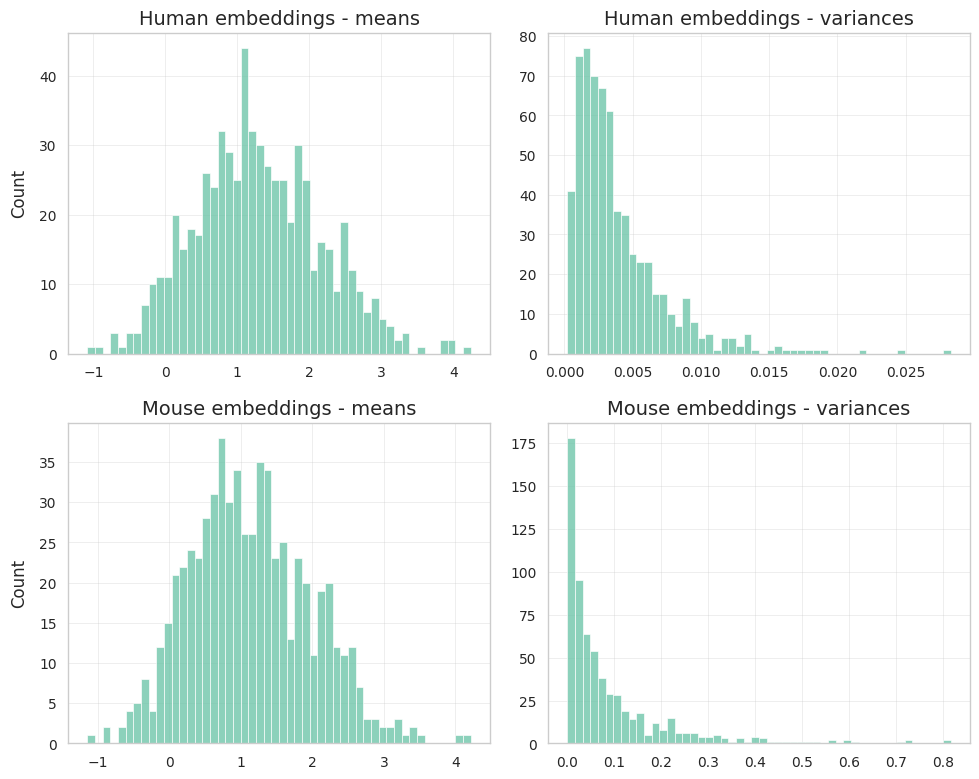

In [8]:
# check embedding features means and variances
# print("Human data - mean of features:", np.mean(human_adata.obsm["X_bulkformer"], axis=0))
# print("Human data - variance of features:", np.var(human_adata.obsm["X_bulkformer"], axis=0))
# print("Mouse data - mean of features:", np.mean(mouse_adata.obsm["X_bulkformer"], axis=0))
# print("Mouse data - variance of features:", np.var(mouse_adata.obsm["X_bulkformer"], axis=0))

# and the mean of means and variances
print(
    "Human data - mean of feature means:",
    np.mean(np.mean(human_adata.obsm["X_bulkformer"], axis=0)),
)
print(
    "Human data - mean of feature variances:",
    np.mean(np.var(human_adata.obsm["X_bulkformer"], axis=0)),
)
print(
    "Mouse data - mean of feature means:",
    np.mean(np.mean(mouse_adata.obsm["X_bulkformer"], axis=0)),
)
print(
    "Mouse data - mean of feature variances:",
    np.mean(np.var(mouse_adata.obsm["X_bulkformer"], axis=0)),
)

# do a 4 subplot figure to compare
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
sns.histplot(np.mean(human_adata.obsm["X_bulkformer"], axis=0), bins=50, ax=axs[0, 0])
axs[0, 0].set_title("Human embeddings - means")
sns.histplot(np.var(human_adata.obsm["X_bulkformer"], axis=0), bins=50, ax=axs[0, 1])
axs[0, 1].set_title("Human embeddings - variances")
sns.histplot(np.mean(mouse_adata.obsm["X_bulkformer"], axis=0), bins=50, ax=axs[1, 0])
axs[1, 0].set_title("Mouse embeddings - means")
sns.histplot(np.var(mouse_adata.obsm["X_bulkformer"], axis=0), bins=50, ax=axs[1, 1])
axs[1, 1].set_title("Mouse embeddings - variances")


# remove count y-label from right plots
axs[0, 1].set_ylabel("")
axs[1, 1].set_ylabel("")

# make tight layout on fig
fig.tight_layout()

In [37]:
def transform_adata_to_X_y_all(adata):
    X = adata.X.copy()
    X_emb = adata.obsm["X_bulkformer"].copy()
    # set y to 1 for inflamed, 0 for healthy
    y = adata.obs["group"].map({"inflammation": 1, "control": 0}).values.astype(int)
    return X, X_emb, y


def transform_adata_to_X_y_takao(adata):
    adata_sub = adata[~adata.obs["takao_status"].isna()].copy()
    X = adata_sub.X.copy()
    X_emb = adata_sub.obsm["X_bulkformer"].copy()
    # set y to 1 for inflamed, 0 for healthy
    y = (
        adata_sub.obs["takao_status"]
        .map({"takao_inflamed": 1, "takao_control": 0})
        .values.astype(int)
    )
    return X, X_emb, y


def transform_adata_to_X_y_acute(adata):
    adata_sub = adata[(adata.obs["group"] == "control") | (adata.obs["infl_acute"])].copy()
    X = adata_sub.X.copy()
    X_emb = adata_sub.obsm["X_bulkformer"].copy()
    # set y to 1 for inflamed, 0 for healthy
    y = adata_sub.obs["infl_acute"].map({True: 1, False: 0}).values.astype(int)
    return X, X_emb, y


def transform_adata_to_X_y_subacute(adata):
    adata_sub = adata[(adata.obs["group"] == "control") | (adata.obs["infl_subacute"])].copy()
    X = adata_sub.X.copy()
    X_emb = adata_sub.obsm["X_bulkformer"].copy()
    # set y to 1 for inflamed, 0 for healthy
    y = adata_sub.obs["infl_subacute"].map({True: 1, False: 0}).values.astype(int)
    return X, X_emb, y


def transform_adata_to_X_y_acute_and_subacute(adata):
    adata_sub = adata[
        (adata.obs["group"] == "control")
        | (adata.obs["infl_acute"])
        | (adata.obs["infl_subacute"])
    ].copy()
    X = adata_sub.X.copy()
    X_emb = adata_sub.obsm["X_bulkformer"].copy()
    # set y to 1 for inflamed, 0 for healthy
    y = (
        (adata_sub.obs["infl_acute"] | adata_sub.obs["infl_subacute"])
        .map({True: 1, False: 0})
        .values.astype(int)
    )
    return X, X_emb, y


def transform_adata_to_X_y_chronic(adata):
    adata_sub = adata[(adata.obs["group"] == "control") | (adata.obs["infl_chronic"])].copy()
    X = adata_sub.X.copy()
    X_emb = adata_sub.obsm["X_bulkformer"].copy()
    # set y to 1 for inflamed, 0 for healthy
    y = adata_sub.obs["infl_chronic"].map({True: 1, False: 0}).values.astype(int)
    return X, X_emb, y


def transform_adata_to_X_y_acute_to_chronic(adata):
    adata_sub = adata[(adata.obs["infl_acute"]) | (adata.obs["infl_chronic"])].copy()
    X = adata_sub.X.copy()
    X_emb = adata_sub.obsm["X_bulkformer"].copy()
    # set y to 1 for inflamed, 0 for healthy
    y = adata_sub.obs["infl_chronic"].map({True: 0, False: 1}).values.astype(int)
    return X, X_emb, y


def transform_adata_to_X_y_acute_subacute_to_chronic(adata):
    adata_sub = adata[
        (adata.obs["infl_acute"]) | (adata.obs["infl_subacute"]) | (adata.obs["infl_chronic"])
    ].copy()
    X = adata_sub.X.copy()
    X_emb = adata_sub.obsm["X_bulkformer"].copy()
    # set y to 1 for inflamed, 0 for healthy
    y = adata_sub.obs["infl_chronic"].map({True: 0, False: 1}).values.astype(int)
    return X, X_emb, y

### Define pipelines

In [38]:
def get_linear_pipelines():
    raw = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(solver="liblinear", random_state=21)),
        ]
    )
    embedding = Pipeline(
        [
            # "scaler", StandardScaler()),
            ("clf", LogisticRegression(solver="liblinear", random_state=21)),
        ]
    )

    return {"Raw": raw, "Embedding": embedding}


def get_nonlinear_pipelines():
    raw = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
            ("scaler", StandardScaler()),
            ("clf", SVC(kernel="rbf", probability=True, C=1.0, gamma="scale", random_state=21)),
        ]
    )
    embedding = Pipeline(
        [
            # ("scaler", StandardScaler()),
            ("clf", SVC(kernel="rbf", probability=True, C=1.0, gamma="scale", random_state=21)),
        ]
    )

    return {"Raw": raw, "Embedding": embedding}

### Evaluate cross-species performance

In [39]:
def evaluate_cross_species(human_adata, mouse_adata, setups):
    all_results = {
        "Linear": {"Raw": {}, "Embedding": {}},
        "Nonlinear": {"Raw": {}, "Embedding": {}},
    }
    all_roc_data = {
        "Linear": {"Raw": {}, "Embedding": {}},
        "Nonlinear": {"Raw": {}, "Embedding": {}},
    }

    for setup_name, transform_func in setups:
        # Prepare data
        human_X, human_X_emb, human_y = transform_func(human_adata)
        mouse_X, mouse_X_emb, mouse_y = transform_func(mouse_adata)

        for model_type, pipeline_func in zip(
            ["Linear", "Nonlinear"], [get_linear_pipelines, get_nonlinear_pipelines]
        ):
            pipelines = pipeline_func()
            for data_type, X_human, X_mouse in [
                ("Raw", human_X, mouse_X),
                ("Embedding", human_X_emb, mouse_X_emb),
            ]:
                pipe = pipelines[data_type]

                # Human → Mouse
                pipe.fit(X_human, human_y)
                y_pred = pipe.predict_proba(X_mouse)[:, 1]
                auroc = roc_auc_score(mouse_y, y_pred)
                all_results[model_type][data_type][f"{setup_name} (Human→Mouse)"] = auroc
                fpr, tpr, _ = roc_curve(mouse_y, y_pred)
                all_roc_data[model_type][data_type][f"{setup_name} (Human→Mouse)"] = (
                    fpr,
                    tpr,
                    auroc,
                )

                # Mouse → Human
                pipe.fit(X_mouse, mouse_y)
                y_pred = pipe.predict_proba(X_human)[:, 1]
                auroc = roc_auc_score(human_y, y_pred)
                all_results[model_type][data_type][f"{setup_name} (Mouse→Human)"] = auroc
                fpr, tpr, _ = roc_curve(human_y, y_pred)
                all_roc_data[model_type][data_type][f"{setup_name} (Mouse→Human)"] = (
                    fpr,
                    tpr,
                    auroc,
                )

    return all_results, all_roc_data


setups = [
    ("All Inflammation Samples vs. Control", transform_adata_to_X_y_all),
    ("Takao Subset for Inflammation vs. Control", transform_adata_to_X_y_takao),
    ("Acute Inflammation vs. Control", transform_adata_to_X_y_acute),
    ("Subacute Inflammation vs. Control", transform_adata_to_X_y_subacute),
    ("Chronic Inflammation vs. Control", transform_adata_to_X_y_chronic),
    ("Acute Inflammation vs. Chronic Inflammation", transform_adata_to_X_y_acute_to_chronic),
]

all_results, all_roc_data = evaluate_cross_species(human_adata, mouse_adata, setups)

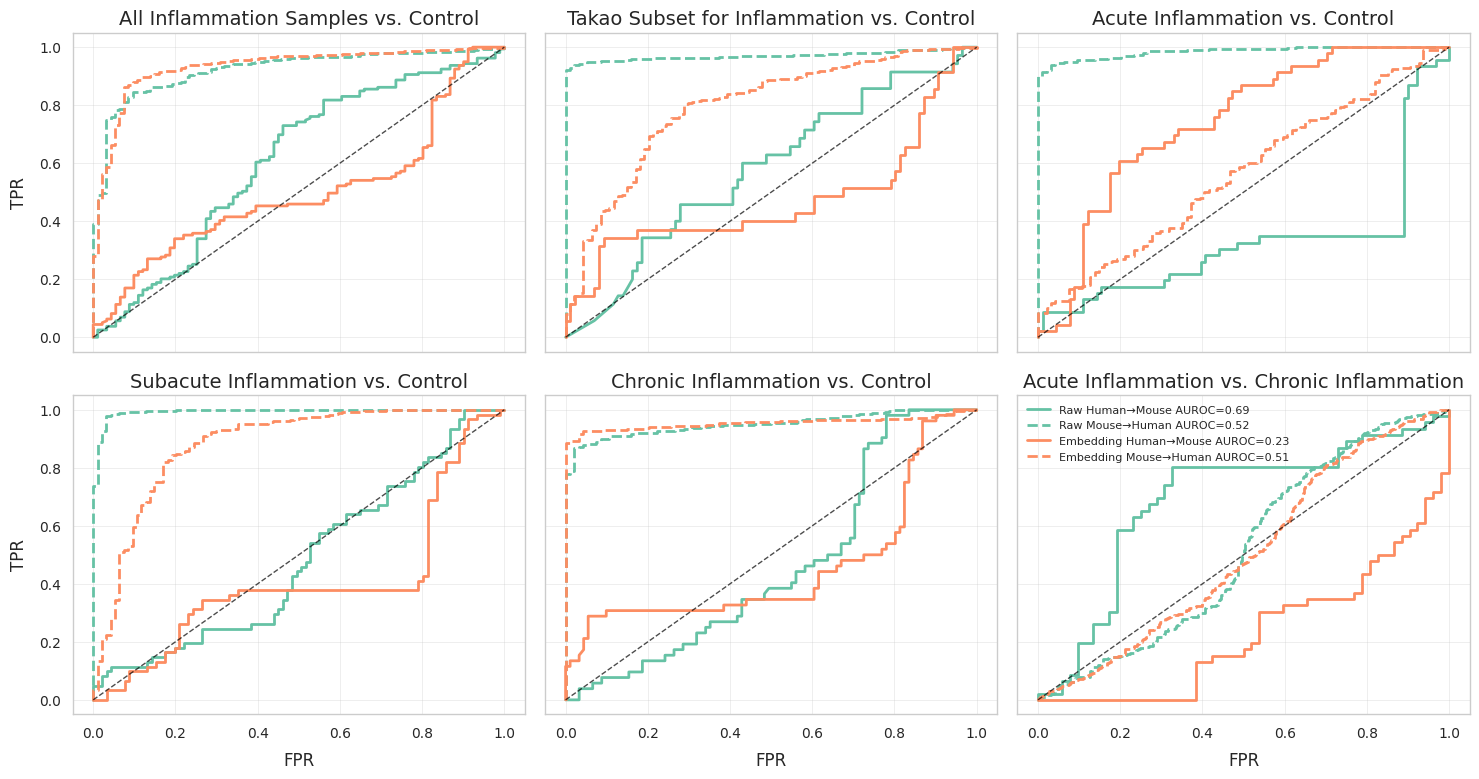

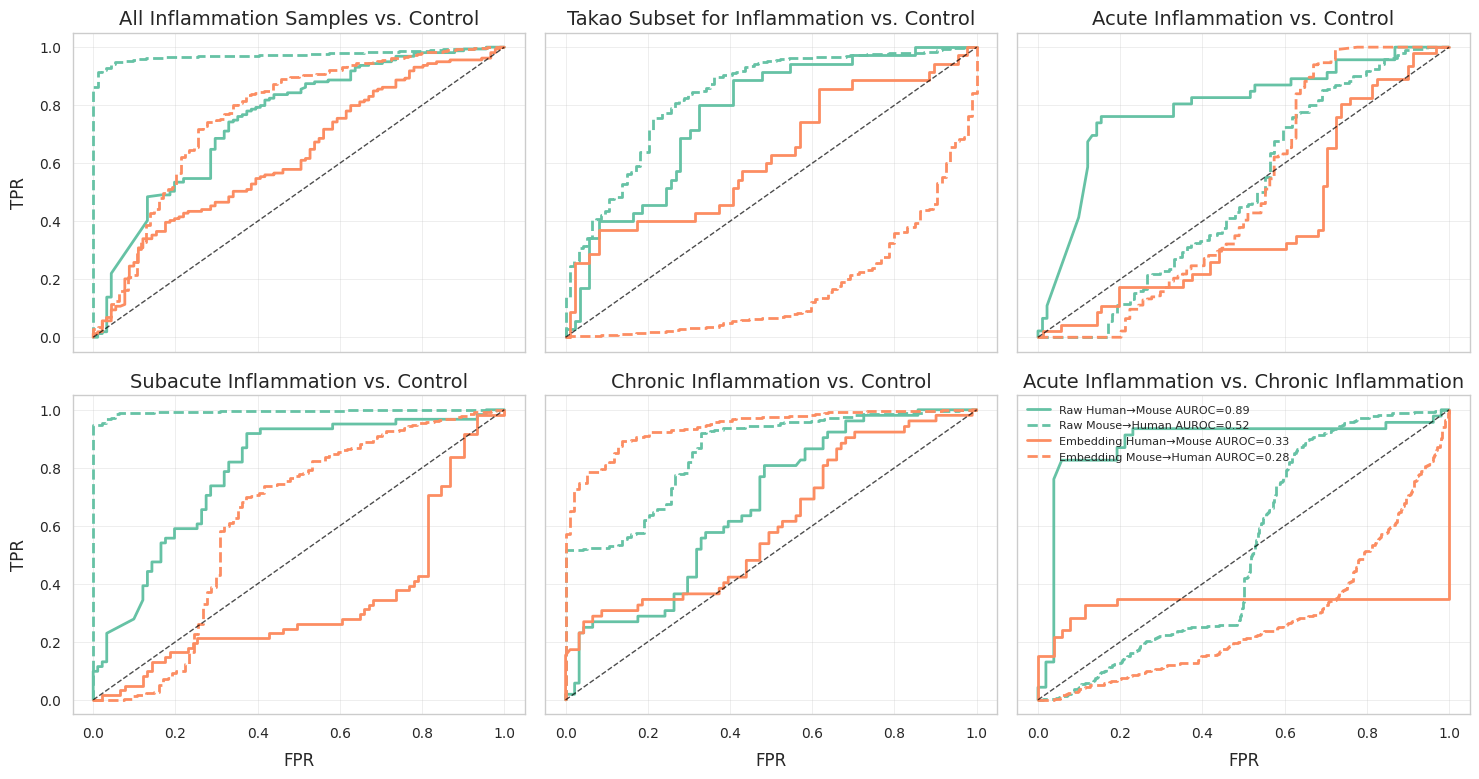

In [40]:
def plot_roc_facet_clean(all_roc_data, setup_order=None):
    """
    Clean ROC facet grid: Linear and Nonlinear separately, four lines per subplot.
    - Only leftmost column and bottom row show axis labels and ticks
    - Only bottom-right subplot shows legend
    - Optional setup_order to enforce subplot order
    """
    import matplotlib.gridspec as gridspec

    colors = {"Raw": "C0", "Embedding": "C1"}
    linestyles = {"Human→Mouse": "-", "Mouse→Human": "--"}

    for model_type in ["Linear", "Nonlinear"]:
        # Extract setups
        example_dict = all_roc_data[model_type]["Raw"]
        setups = sorted({key.split(" (")[0] for key in example_dict.keys()})
        if setup_order is not None:
            setups = [s for s in setup_order if s in setups]

        n = len(setups)
        cols = 3
        rows = (n + cols - 1) // cols
        fig = plt.figure(figsize=(cols * 5, rows * 4))
        gs = gridspec.GridSpec(rows, cols, figure=fig)

        for i, setup in enumerate(setups):
            ax = fig.add_subplot(gs[i])
            for data_type in ["Raw", "Embedding"]:
                for direction in ["Human→Mouse", "Mouse→Human"]:
                    key = f"{setup} ({direction})"
                    if key in all_roc_data[model_type][data_type]:
                        fpr, tpr, auroc = all_roc_data[model_type][data_type][key]
                        ax.plot(
                            fpr,
                            tpr,
                            color=colors[data_type],
                            linestyle=linestyles[direction],
                            lw=2,
                            label=f"{data_type} {direction} AUROC={auroc:.2f}",
                        )

            ax.plot([0, 1], [0, 1], "--", color="black", lw=1, alpha=0.7)
            ax.set_title(setup)

            # Only show x-labels for bottom row
            if i // cols == rows - 1:
                ax.set_xlabel("FPR")
            else:
                ax.set_xticklabels([])
                ax.set_xlabel("")

            # Only show y-labels for leftmost column
            if i % cols == 0:
                ax.set_ylabel("TPR")
            else:
                ax.set_yticklabels([])
                ax.set_ylabel("")

            # Show legend only on bottom-right subplot
            if i == n - 1:
                ax.legend(fontsize=8)
        plt.tight_layout()
        plt.show()


plot_roc_facet_clean(
    all_roc_data,
    setup_order=[
        "All Inflammation Samples vs. Control",
        "Takao Subset for Inflammation vs. Control",
        "Acute Inflammation vs. Control",
        "Subacute Inflammation vs. Control",
        "Chronic Inflammation vs. Control",
        "Acute Inflammation vs. Chronic Inflammation",
    ],
)

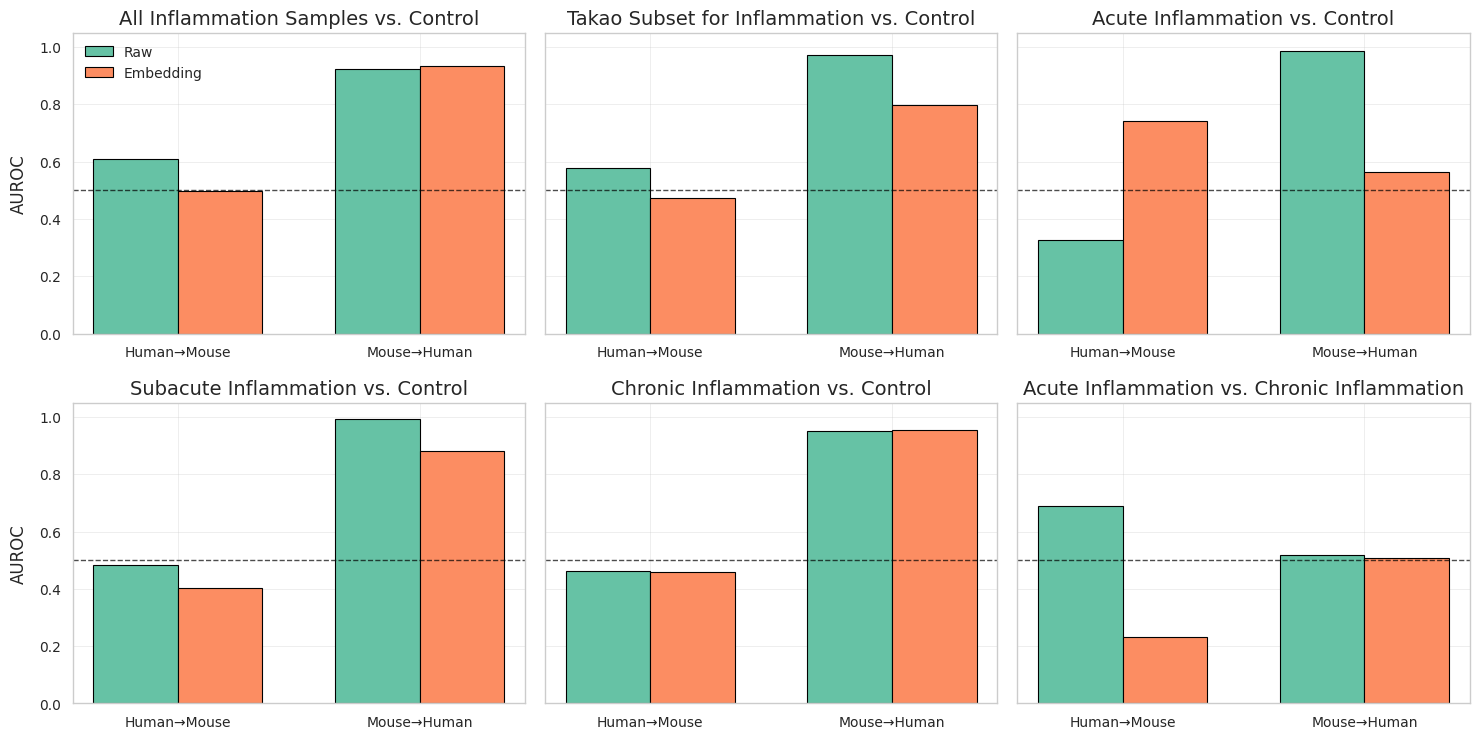

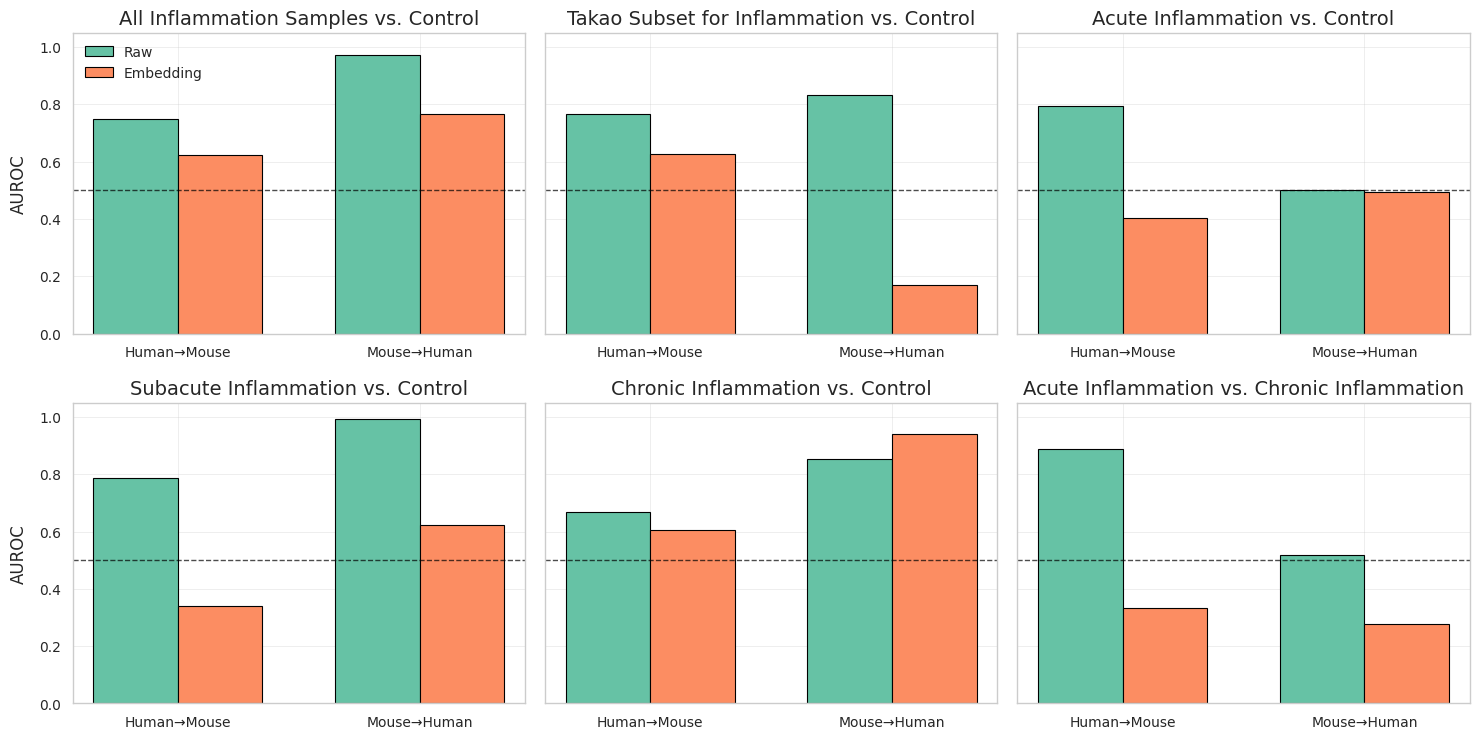

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


def plot_auroc_bar_clean_sns_top_legend(all_results, setup_order=None):
    """
    AUROC barplot for cross-species setups.
    - Groups: Raw/Embedding side by side for each direction
    - Colors by Raw vs Embedding using sns.Set2
    - Leftmost column shows Y-axis label 'AUROC'
    - Legend on top-left
    - Horizontal line at 0.5 for random chance
    """
    palette = sns.color_palette("Set2", 2)  # Raw, Embedding
    directions = ["Human→Mouse", "Mouse→Human"]
    data_types = ["Raw", "Embedding"]

    for model_type in ["Linear", "Nonlinear"]:
        example_dict = all_results[model_type]["Raw"]
        setups = sorted({key.split(" (")[0] for key in example_dict.keys()})
        if setup_order is not None:
            setups = [s for s in setup_order if s in setups]

        n = len(setups)
        cols = 3
        rows = (n + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
        axes = axes.flatten()

        for i, setup in enumerate(setups):
            ax = axes[i]
            # Bar positions
            x = np.arange(len(directions))  # 0=H→M, 1=M→H
            width = 0.35
            for j, data_type in enumerate(data_types):
                heights = [
                    all_results[model_type][data_type].get(f"{setup} ({dir_})", np.nan)
                    for dir_ in directions
                ]
                ax.bar(
                    x + (j - 0.5) * width,
                    heights,
                    width=width,
                    color=palette[j],
                    edgecolor="black",
                    label=data_type if i == 0 else "",
                )

            # Horizontal line at 0.5
            ax.axhline(0.5, color="black", linestyle="--", linewidth=1, alpha=0.7)

            ax.set_xticks(x)
            ax.set_xticklabels(directions)
            ax.set_ylim(0, 1.05)
            ax.set_title(setup)

            # Y-axis label only on leftmost column
            if i % cols == 0:
                ax.set_ylabel("AUROC")
            else:
                ax.set_yticklabels([])

        # Remove extra axes
        for j in range(len(setups), len(axes)):
            fig.delaxes(axes[j])

        axes[0].legend()

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


plot_auroc_bar_clean_sns_top_legend(
    all_results,
    setup_order=[
        "All Inflammation Samples vs. Control",
        "Takao Subset for Inflammation vs. Control",
        "Acute Inflammation vs. Control",
        "Subacute Inflammation vs. Control",
        "Chronic Inflammation vs. Control",
        "Acute Inflammation vs. Chronic Inflammation",
    ],
)

Interpretation: Non-linear probes overfit the training manifold (specific to one species) and do not generalize well to the other species. Linear probes are able to extrapolate along the main axes of variation that are shared between species.

### Assessing dimensionality to figure out why non-linear models fail

In [42]:
human_X, human_X_emb, human_y = transform_adata_to_X_y_all(human_adata)
mouse_X, mouse_X_emb, mouse_y = transform_adata_to_X_y_all(mouse_adata)

In [43]:
def intrinsic_dimensionality(X_emb):
    # Participation ratio = (sum(variance)^2) / sum(variance^2)
    cov = np.cov(X_emb.T)
    eigvals = np.linalg.eigvalsh(cov)
    pr = (eigvals.sum() ** 2) / (eigvals**2).sum()
    return pr


pr_human = intrinsic_dimensionality(human_X_emb)
pr_mouse = intrinsic_dimensionality(mouse_X_emb)
print(f"Participation ratio (intrinsic dim): Human={pr_human:.2f}, Mouse={pr_mouse:.2f}")

Participation ratio (intrinsic dim): Human=7.52, Mouse=1.20


/tmp/ipykernel_1930692/2301651458.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,0].set_xticklabels(axes[1,0].get_xticklabels())
/tmp/ipykernel_1930692/2301651458.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_pr, x="Species", y="Participation Ratio", ax=axes[1,1], palette="Set2")


7.516941050676281 1.2046045068910685


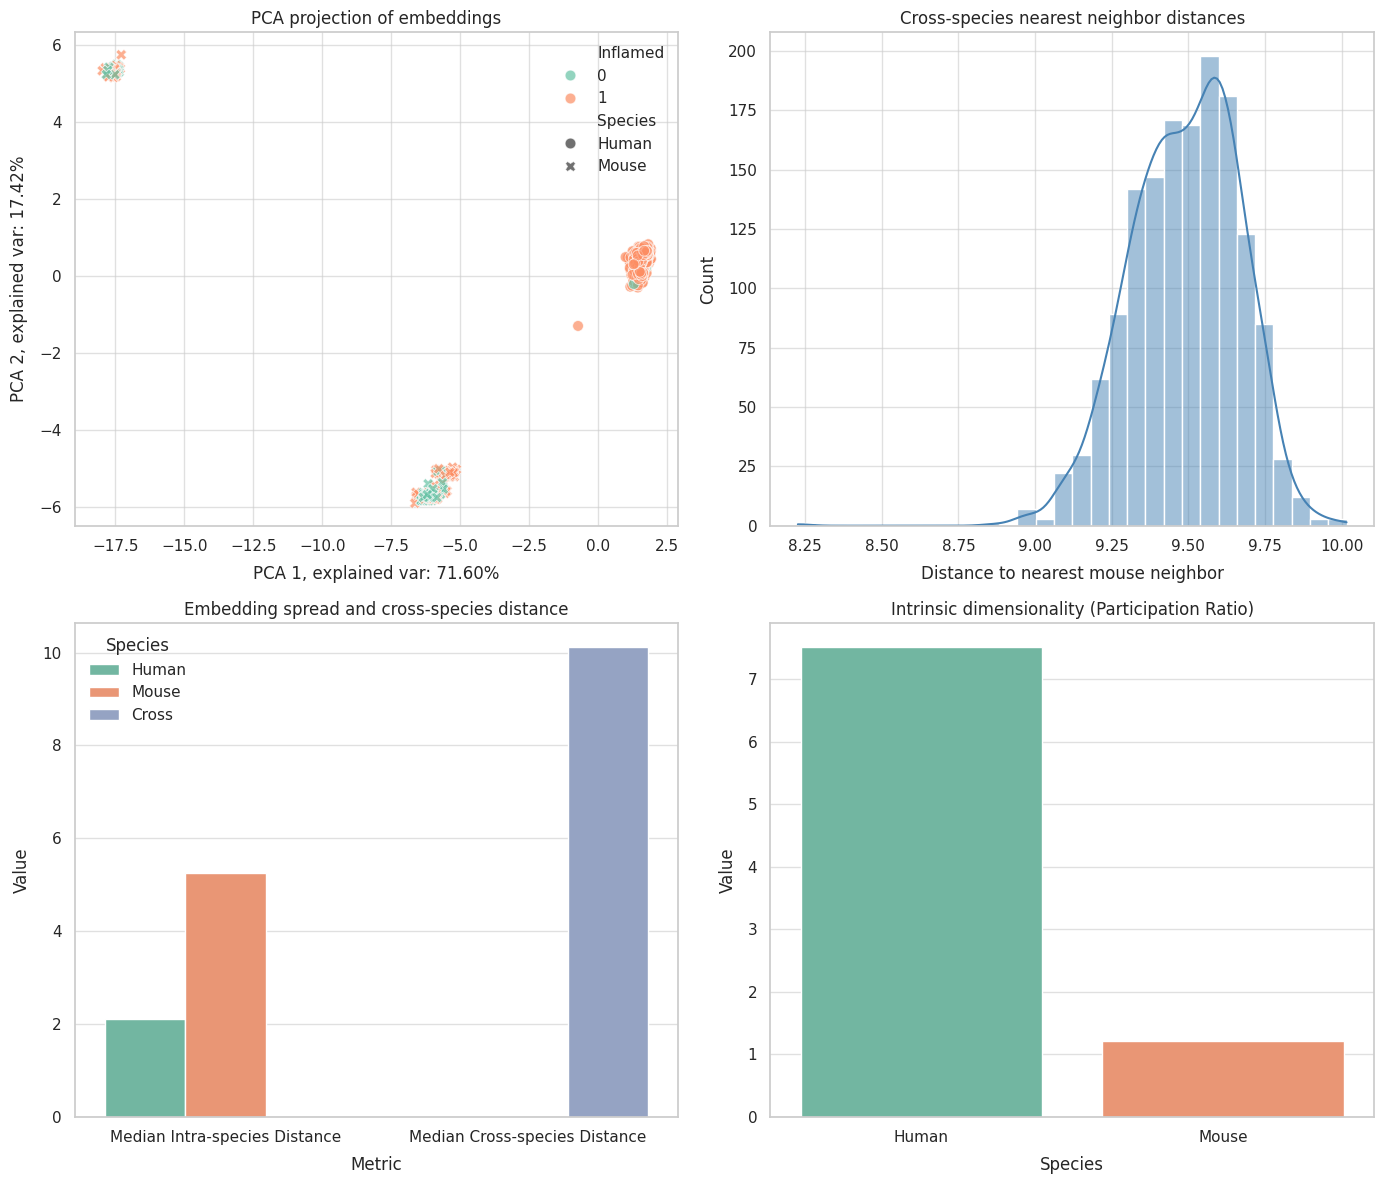

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist, pdist
import seaborn as sns
from sklearn.decomposition import PCA


def plot_cross_species_diagnostics(
    human_X_emb, human_y, mouse_X_emb, mouse_y, umap_random_state=21
):
    sns.set(style="whitegrid", palette="Set2")

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    ####### 1. PCA projection #######
    pca = PCA(n_components=2)
    X_all = np.vstack([human_X_emb, mouse_X_emb])
    X_2d = pca.fit_transform(X_all)

    df_pca = pd.DataFrame(
        {
            "Dim1": X_2d[:, 0],
            "Dim2": X_2d[:, 1],
            "Species": ["Human"] * len(human_y) + ["Mouse"] * len(mouse_y),
            "Inflamed": np.hstack([human_y, mouse_y]),
        }
    )

    sns.scatterplot(
        data=df_pca,
        x="Dim1",
        y="Dim2",
        hue="Inflamed",
        style="Species",
        ax=axes[0, 0],
        s=60,
        alpha=0.7,
    )
    axes[0, 0].set_title("PCA projection of embeddings")
    axes[0, 0].set_xlabel(
        "PCA 1, explained var: {:.2f}%".format(pca.explained_variance_ratio_[0] * 100)
    )
    axes[0, 0].set_ylabel(
        "PCA 2, explained var: {:.2f}%".format(pca.explained_variance_ratio_[1] * 100)
    )

    ####### 2. Cross-species nearest neighbor distances #######
    dists = cdist(human_X_emb, mouse_X_emb)
    min_dists = dists.min(axis=1)  # nearest mouse neighbor for each human point
    sns.histplot(min_dists, bins=30, kde=True, ax=axes[0, 1], color="steelblue")
    axes[0, 1].set_title("Cross-species nearest neighbor distances")
    axes[0, 1].set_xlabel("Distance to nearest mouse neighbor")
    axes[0, 1].set_ylabel("Count")

    ####### 3. Covariance / spread #######
    cov_trace_h = np.trace(np.cov(human_X_emb.T))
    cov_trace_m = np.trace(np.cov(mouse_X_emb.T))
    median_intra_h = np.median(pdist(human_X_emb))
    median_intra_m = np.median(pdist(mouse_X_emb))
    median_cross = np.median(dists)  # Median of ALL human-to-mouse distances

    df_cov = pd.DataFrame(
        {
            "Metric": [
                "Covariance Trace",
                "Median Intra-species Distance",
                "Median Cross-species Distance",
            ],
            "Human": [cov_trace_h, median_intra_h, np.nan],
            "Mouse": [cov_trace_m, median_intra_m, np.nan],
            "Cross": [np.nan, np.nan, median_cross],
        }
    ).melt(id_vars="Metric", var_name="Species", value_name="Value")

    df_cov = pd.DataFrame(
        {
            "Metric": ["Median Intra-species Distance", "Median Cross-species Distance"],
            "Human": [median_intra_h, np.nan],
            "Mouse": [median_intra_m, np.nan],
            "Cross": [np.nan, median_cross],
        }
    ).melt(id_vars="Metric", var_name="Species", value_name="Value")

    sns.barplot(data=df_cov, x="Metric", y="Value", hue="Species", ax=axes[1, 0], palette="Set2")
    axes[1, 0].set_title("Embedding spread and cross-species distance")
    axes[1, 0].set_ylabel("Value")
    axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels())

    ####### 4. Intrinsic dimensionality (Participation Ratio) #######
    def participation_ratio(X):
        cov = np.cov(X.T)
        eigvals = np.linalg.eigvalsh(cov)
        pr = (eigvals.sum() ** 2) / (eigvals**2).sum()
        return pr

    pr_h = participation_ratio(human_X_emb)
    pr_m = participation_ratio(mouse_X_emb)

    df_pr = pd.DataFrame({"Species": ["Human", "Mouse"], "Participation Ratio": [pr_h, pr_m]})

    print(pr_h, pr_m)

    sns.barplot(data=df_pr, x="Species", y="Participation Ratio", ax=axes[1, 1], palette="Set2")
    axes[1, 1].set_title("Intrinsic dimensionality (Participation Ratio)")
    axes[1, 1].set_ylabel("Value")

    plt.tight_layout()
    plt.show()


plot_cross_species_diagnostics(human_X_emb, human_y, mouse_X_emb, mouse_y)

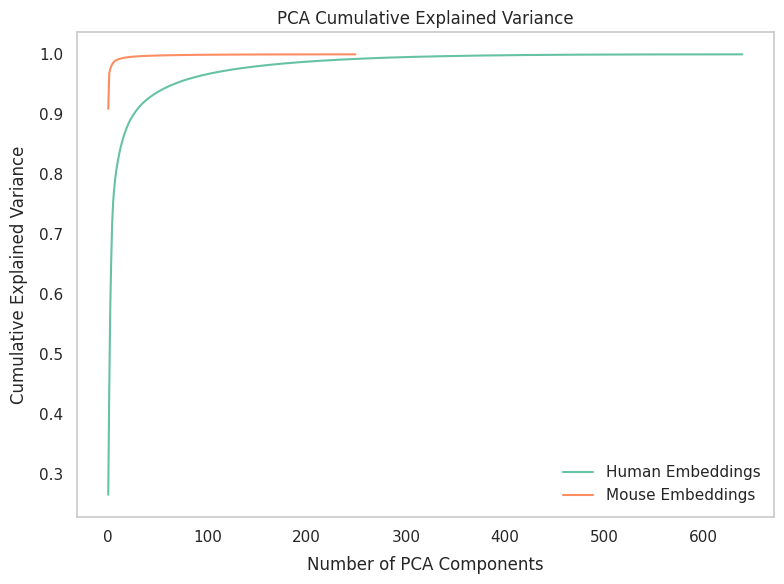

In [45]:
# plot cumulative variance explained by PCA components, separately for human and mouse embeddings
def plot_pca_cumulative_variance(human_X_emb, mouse_X_emb):
    pca_h = PCA()
    pca_h.fit(human_X_emb)
    cum_var_h = np.cumsum(pca_h.explained_variance_ratio_)

    pca_m = PCA()
    pca_m.fit(mouse_X_emb)
    cum_var_m = np.cumsum(pca_m.explained_variance_ratio_)

    plt.figure(figsize=(8, 6))
    plt.plot(range(0, len(cum_var_h)), cum_var_h, label="Human Embeddings")
    plt.plot(range(0, len(cum_var_m)), cum_var_m, label="Mouse Embeddings")
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("PCA Cumulative Explained Variance")
    plt.legend()
    plt.grid()
    plt.show()


plot_pca_cumulative_variance(human_X_emb, mouse_X_emb)